# Image classification performed on the MNIST dataset

## Preparing the data
First we load the MNIST dataset using Sklearn helper

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

Segmentize the dataset into the features X and the labels y and show a sample digit. The MNIST data is stored in vectors (i.e. every 2D image is stored in a 1D vector of intensity values)

(-0.5, 27.5, 27.5, -0.5)

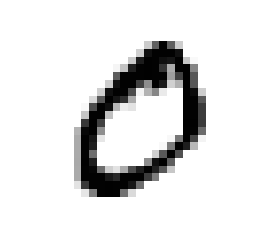

In [2]:
X,y = mnist['data'], mnist['target']
img = np.reshape(X[0,:],(28,28))
plt.imshow(img,  cmap=matplotlib.cm.binary)
plt.axis('off')

Separate the dataset into a test and training set and then shuffle the training set to ensure that each cross-validation fold contains sufficient examples from each number

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_idx = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

## Binary Classification

We will first try to identify one digit using a Stochastic Gradient Descent (SGD) classifier (for use in classification, which is different from a regressor, https://en.wikipedia.org/wiki/Stochastic_gradient_descent) and evaluate the performance of the model, however, keep in mind that it is different to evaluate a classifier than a regressor

In [4]:
# Define the labels for the digit 5
y_train_0 = (y_train==0)
y_test_0 = (y_test==0)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_0)
sgd_clf.predict(X_test[0,:])

/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ True], dtype=bool)

Evaluating the performance of the classifier using cross-validation. When using the cross_val_score function from sklearn the algorithm outputs the RMSE or the percentage accuracy of classification depending on the type of algorithm being used (regression or classification)

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
'''
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_0):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.9502, 0.96565 and 0.96495
    
    # Hard coded cross-validation algorithm
    '''
cross_val_score(sgd_clf, X_train, y_train_0, cv=3)

array([ 0.9880006 ,  0.9849    ,  0.98354918])

This gives above 95% accuracy for the predictions made by this model. However, accuracy is usually not a good predictor of the performance of a classification algorithm, specially when the data is skewed or some classes are more common than others. For example, what would happen if one always says its never 0

In [6]:
# This code makes our own sklearn estimator for never predicting 0
from sklearn.base import BaseEstimator
class never_zero(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
never_zero_clf = never_zero()
cross_val_score(never_zero_clf, X_train, y_train_0, cv=3, scoring='accuracy')

array([ 0.90105,  0.9022 ,  0.9006 ])

The obtained accuracy is still very good, showing that accuracy might not be the best performance estimator for classification

## Using a confusion matrix to evaluate the model performance

In [51]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3)

Cross-val predict gives you the predictions for each fold in the training set without using the data from that fold to train, that is, say you select 3 as the number of folds, the algorithm trains in the first 2 folds, and predicts on the 3rd fold and so on, such that the predicted data was always obtained using fresh trained data.

Then, given these results one can do a confusion matrix which has the format in binary classification: the count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}. Also the predicted class goes on the x direction and the actual class in the y direction

In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_0, y_train_pred)

array([[53795,   282],
       [  589,  5334]])

Based on the results of the confusion matrix it can be seen that the true positives, found in C{1,1}, are only a small number of the predictions made, compared to the number of true negatives C{0,0}. An algorithm that says no most of the time will perform well here. A measurement of the performance of the classification algorithm is given by $$presicion = \frac{TP}{TP+FP}$$. However precision can be misleading if the number of examples present is small. Another metric used to accompany the performance of the algorithm is the true positive rate (TPR) or the recall, given by $$recall = \frac{TP}{TP+FN}$$ which corresponds to the ratio of positive instances correctly detected by the classifier. <img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg">

In [10]:
# Use sklearn to evaluate the classification
from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision:',precision_score(y_train_0,y_train_pred)) 
print('Recall:', recall_score(y_train_0,y_train_pred))
print('F1 Score:', f1_score(y_train_0,y_train_pred))

Precision: 0.949786324786
Recall: 0.900557150093
F1 Score: 0.92451685588


The prediction-recall tradeoff can be evaluated by changing the threshold at which predictions are made. The larger the threshold, the better the precision and the smaller the recall. If one knows the prediction scores from the binary classifier, one can then threshold these values and see how performance changes.

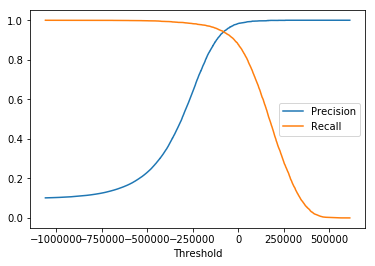

In [32]:
from sklearn.metrics import precision_recall_curve
y_scores = sgd_clf.decision_function(X_train)
precisions,recalls, thresholds = precision_recall_curve(y_train_0, y_scores)
plt.plot(thresholds,precisions[:-1], label='Precision')
plt.plot(thresholds,recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()

From this analysis the optimal threshold for equal recall and precision is given by:`

In [36]:
optimal_thresh = thresholds[precisions[:-1]==recalls[:-1]]
y_train_pred = y_scores>optimal_thresh
print('Precision:',precision_score(y_train_0,y_train_pred)) 
print('Recall:', recall_score(y_train_0,y_train_pred))
print('F1 Score:', f1_score(y_train_0,y_train_pred))

Precision: 0.940898345154
Recall: 0.940739490123
F1 Score: 0.940818910933


This curve shows the tradeoff between precision and recall on the different possible thresholds. Another curve that serves for this purpose is the ROC which compares the true positive rate to the false positive rate

The AUC is: 0.995017141393


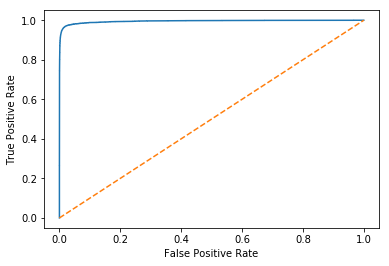

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
auc_score = roc_auc_score(y_train_0, y_scores)
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('The AUC is:',auc_score)

The ROC curve and the PR curve both give different insights into the data. The PR curve should be used when the data of interest is rare in order to know the tradeoff between how many of the data of interest are correctly predicted and how many of the selected elements are relevant, for example you might want to have all of the relevant events selected (a very small threshold), at the expense that many of the selected events correspond to irrelevant events. On the other hand, if there is an equal number of positive and negative scenarios, then the ROC curve can be used

## Multiclass Classification

Many of the same classifiers can be used in order to perform multiclass classification, for example

In [45]:
sgd_clf_multi = SGDClassifier(random_state=42)
sgd_clf_multi.fit(X_train, y_train)
print('Scores before scaling:',cross_val_score(sgd_clf_multi,X_train,y_train, cv=3, scoring='accuracy'))

Scores before scaling: [ 0.83723255  0.87414371  0.84912737]


In [44]:
# Scale the inputs to get better accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
print('Scores after scaling:',cross_val_score(sgd_clf_multi,X_train_scaled,y_train, cv=3, scoring='accuracy'))

/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Scores after scaling: [ 0.90966807  0.90649532  0.9106366 ]


For multicomponent classification a confusion matrix can be confusing (pun intended) if only filled with numbers. For a multiclass confusion matrix,  Instead a visual representation of the confusion matrix might be more appropriate as follows:

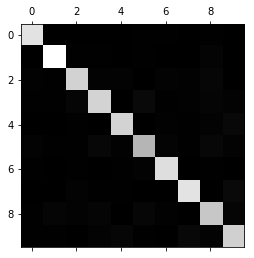

In [54]:
y_train_pred = cross_val_predict(sgd_clf_multi,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
plt.matshow(conf_mx,cmap='gray')

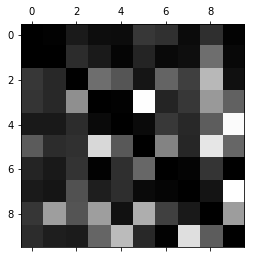

In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap='gray')

Interpreting the above error matrix, and remembering that the columns represent the predicted values and the rows the actual classes, one can see that the 8 and 9 columns are bright, which tells us that many digits end up being misclassified as either 8 or 9. On the other hand, the 2 row is also relatively bright, which tells us the the 2s often get misclassified. By tuning the hyperparameters using a GridSearchCV one can imporve the performance of the algorithms. Reference the other notebook to see how to do that.